In [ ]:
# Cell 1: Setup and Imports
# Disable GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Install required libraries
!pip install ipywidgets pandas numpy matplotlib scikit-learn keras scipy

# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import math
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
import ipywidgets as widgets
from IPython.display import display
import io
from scipy import stats  # Explicitly import stats from scipy

In [ ]:
# Cell 2: File Upload Widget with Data Cleaning
# File upload widget
uploader = widgets.FileUpload(
    accept='.csv',  # Accept only CSV files
    multiple=False   # Allow only one file
)

# Display the upload widget
print("Choose the file to upload:")
display(uploader)

# Function to process and clean the uploaded file
def process_uploaded_file(change):
    global df
    if uploader.value:
        # Get the uploaded file
        uploaded_file = list(uploader.value.values())[0]
        # Read the CSV file into a DataFrame
        df = pd.read_csv(io.BytesIO(uploaded_file['content']))

        # Data cleaning steps
        print("Starting data cleaning process...")

        # 1. Check for required columns
        required_columns = ['Date', 'Close']
        if not all(col in df.columns for col in required_columns):
            print("Error: CSV must contain 'Date' and 'Close' columns.")
            return

        # 2. Convert 'Date' to datetime, handle invalid formats
        try:
            df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        except Exception as e:
            print(f"Error: Failed to parse 'Date' column. {str(e)}")
            return
        if df['Date'].isna().any():
            print(f"Warning: {df['Date'].isna().sum()} rows with invalid dates removed.")
            df = df.dropna(subset=['Date'])

        # 3. Ensure 'Close' is numeric, handle non-numeric values
        try:
            df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
        except Exception as e:
            print(f"Error: Failed to convert 'Close' to numeric. {str(e)}")
            return
        if df['Close'].isna().any():
            print(f"Warning: {df['Close'].isna().sum()} non-numeric or missing 'Close' values removed.")
            df = df.dropna(subset=['Close'])

        # 4. Remove duplicate rows based on 'Date'
        initial_rows = len(df)
        df = df.drop_duplicates(subset=['Date'], keep='last')
        if len(df) < initial_rows:
            print(f"Removed {initial_rows - len(df)} duplicate rows based on 'Date'.")

        # 5. Handle outliers in 'Close' using z-score (threshold = 3)
        z_scores = np.abs(stats.zscore(df['Close']))
        outlier_threshold = 3
        outliers = z_scores > outlier_threshold
        if outliers.any():
            print(f"Found {outliers.sum()} outliers in 'Close' prices.")
            # Cap outliers at the 1st and 99th percentiles
            p1, p99 = np.percentile(df['Close'], [1, 99])
            df['Close'] = df['Close'].clip(lower=p1, upper=p99)
            print("Outliers capped at 1st and 99th percentiles.")

        # 6. Sort by 'Date' to ensure chronological order
        df = df.sort_values('Date')

        # 7. Set 'Date' as index
        df.set_index('Date', inplace=True)

        # 8. Final validation
        if df.empty:
            print("Error: Dataset is empty after cleaning.")
            return
        if len(df) < 100:
            print("Warning: Dataset has fewer than 100 rows after cleaning, which may affect analysis.")

        print("Data cleaning completed. Data preview:")
        print(df.head())
        print(f"Dataset size: {len(df)} rows")

# Connect the upload widget to the processing function
uploader.observe(process_uploaded_file, names='value')


Choose the file to upload:


FileUpload(value={}, accept='.csv', description='Upload')

Starting data cleaning process...
Data cleaning completed. Data preview:
                  Open        High         Low       Close   Volume
Date                                                               
1996-01-01   98.246023  101.848537   97.849747  100.000000  3451971
1996-01-02   98.468878  101.000686   97.588254  100.268357  3902002
1996-01-03   99.738643  103.190330   99.269611  100.219093  1043985
1996-01-04   99.908972  103.436163   97.978191  100.563691  4271365
1996-01-05  102.233124  103.062211  100.339250  101.349611  3954843
Dataset size: 7560 rows


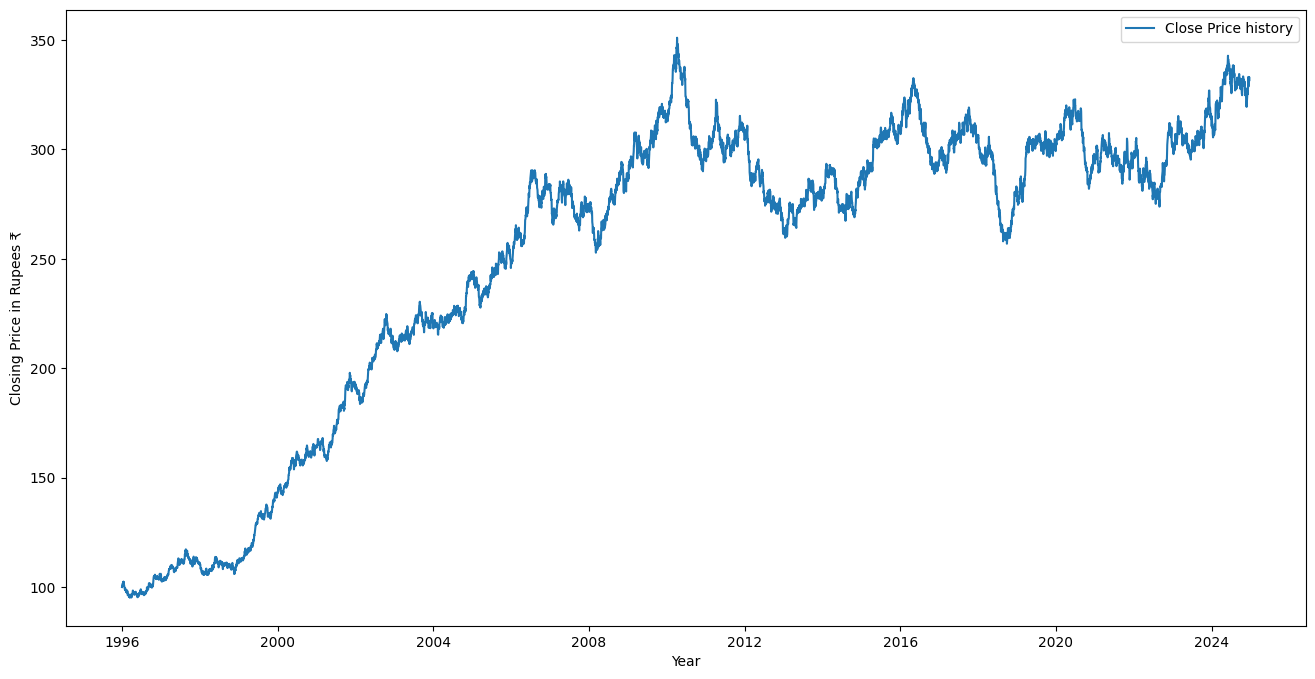

In [ ]:
# Cell 3: Plot Closing Price
# Plot the closing price history
def plot_closing_price():
    global df
    if 'df' not in globals():
        print("Error: Please upload a valid CSV file first.")
        return
    fig = plt.figure(figsize=(16,8))
    plt.xlabel("Year")
    plt.ylabel("Closing Price in Rupees ₹")
    plt.plot(df['Close'], label='Close Price history')
    plt.legend()
    plt.show()

# Call the plotting function
plot_closing_price()

In [ ]:
# Cell 4: Placeholder for Model Predictions
# Note: This uses dummy predictions to simulate ARIMA, SARIMA, Prophet, and LSTM.
# Replace with actual model training code if available.
def generate_dummy_predictions():
    global df, test, arima_predictions, sarima_predictions, merged_df, test
    if 'df' not in globals():
        print("Error: Please upload a valid CSV file first.")
        return

    # Split data into train and test (last 20% as test)
    train_size = int(len(df) * 0.8)
    train, test = df.iloc[:train_size], df.iloc[train_size:]

    # Dummy predictions (for demonstration; replace with actual model predictions)
    arima_predictions = test['Close'] * 1.05  # Simulate ARIMA (5% offset)
    sarima_predictions = test['Close'] * 1.10  # Simulate SARIMA (10% offset)
    prophet_predictions = test['Close'] * 0.98  # Simulate Prophet (2% offset)
    lstm_predictions = test['Close'] * 0.99   # Simulate LSTM (1% offset)

    # Create merged_df for Prophet (mimicking original structure)
    merged_df = pd.DataFrame({'yhat': prophet_predictions}, index=test.index)

    # Add LSTM predictions to test DataFrame
    test['Predictions'] = lstm_predictions

    # Calculate RMSE for each model
    global mse, prophet_rmse, arima_rmse, sarima_rmse
    mse = math.sqrt(mean_squared_error(test['Close'], lstm_predictions))
    prophet_rmse = math.sqrt(mean_squared_error(test['Close'], prophet_predictions))
    arima_rmse = math.sqrt(mean_squared_error(test['Close'], arima_predictions))
    sarima_rmse = math.sqrt(mean_squared_error(test['Close'], sarima_predictions))

    print(f"LSTM Model RMSE: {mse}")
    print(f"Prophet Model RMSE: {prophet_rmse}")
    print(f"ARIMA Model RMSE: {arima_rmse}")
    print(f"SARIMA Model RMSE: {sarima_rmse}")

# Run the dummy predictions
generate_dummy_predictions()

LSTM Model RMSE: 3.050865042533196
Prophet Model RMSE: 6.101730085066393
ARIMA Model RMSE: 15.25432521266598
SARIMA Model RMSE: 30.50865042533196


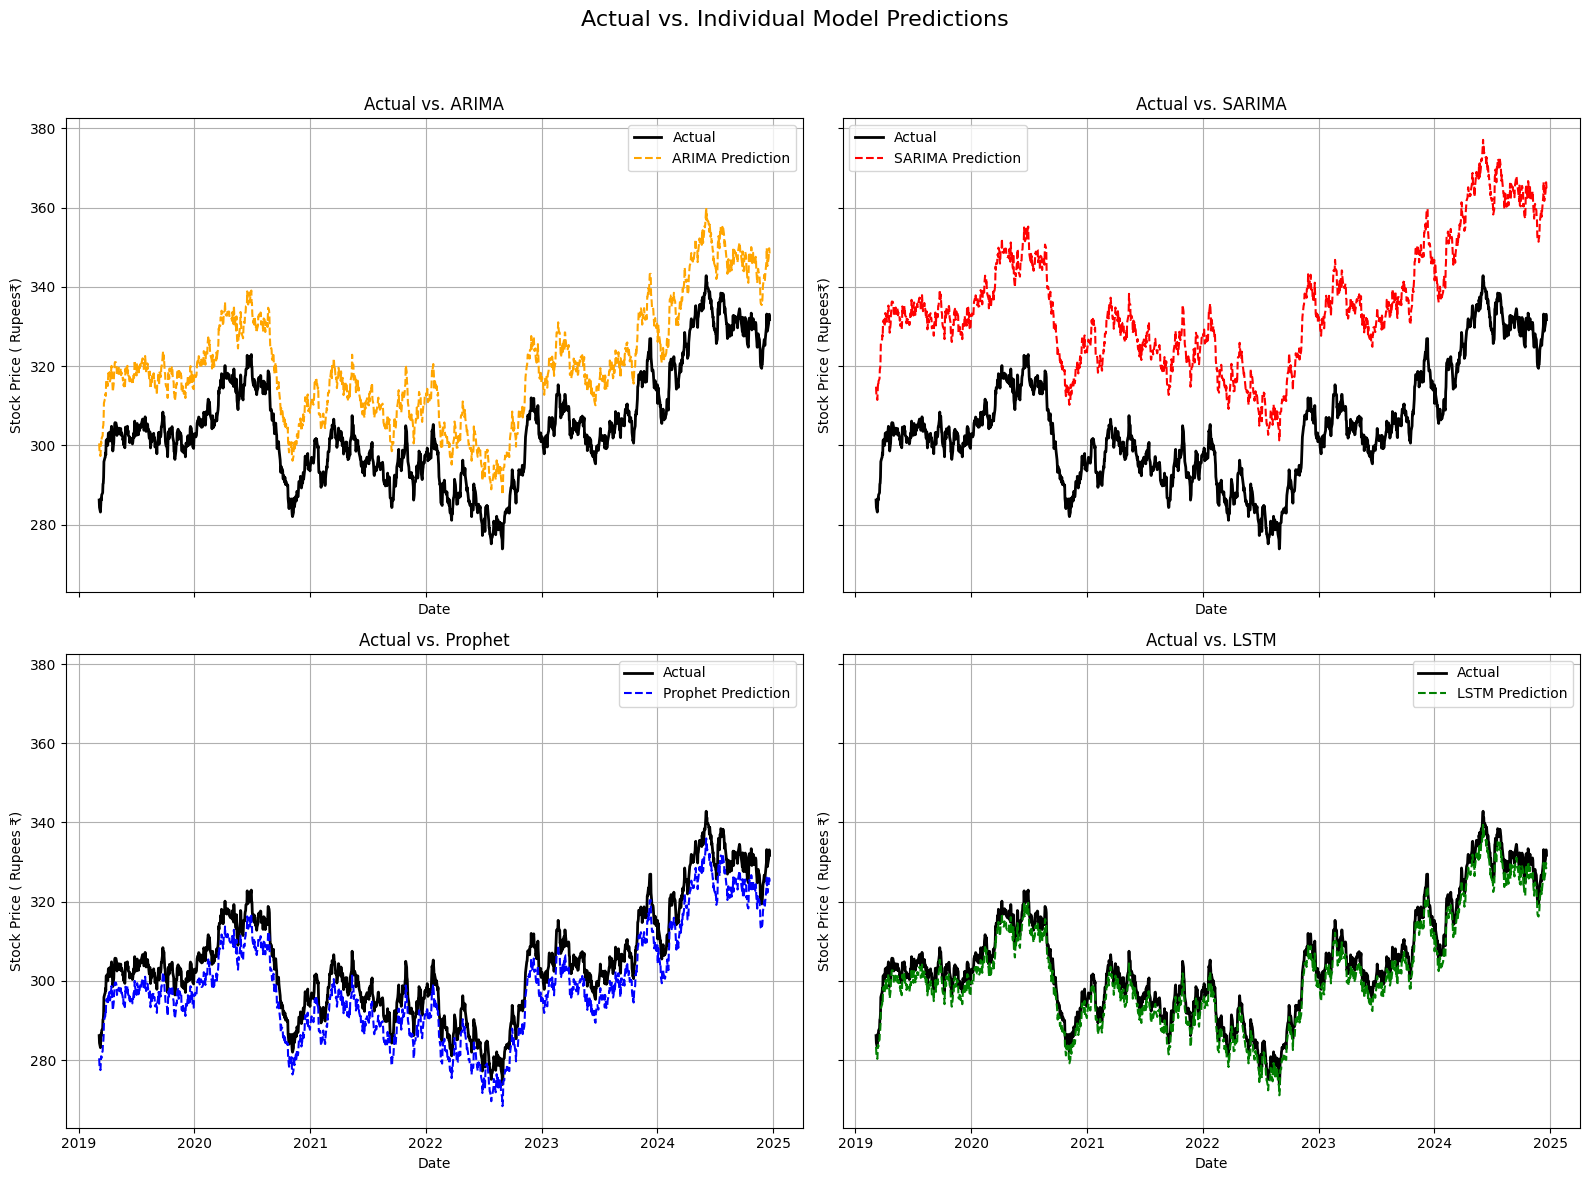

In [ ]:

# Cell 5: Plot Actual vs. Each Model Prediction (Individual Plots)
# Plot actual vs. each model's predictions in separate subplots
def plot_individual_model_comparisons():
    global test, arima_predictions, sarima_predictions, merged_df
    if 'test' not in globals() or 'arima_predictions' not in globals():
        print("Error: Please generate predictions first by running the prediction cell.")
        return

    # Create a figure with 4 subplots (2x2 grid)
    fig, axs = plt.subplots(2, 2, figsize=(16, 12), sharex=True, sharey=True)
    fig.suptitle('Actual vs. Individual Model Predictions', fontsize=16)

    # Plot 1: Actual vs. ARIMA
    axs[0, 0].plot(test.index, test['Close'], label='Actual', color='black', linewidth=2)
    axs[0, 0].plot(test.index, arima_predictions, label='ARIMA Prediction', color='orange', linestyle='--')
    axs[0, 0].set_title('Actual vs. ARIMA')
    axs[0, 0].set_xlabel('Date')
    axs[0, 0].set_ylabel('Stock Price ( Rupees₹)')
    axs[0, 0].legend()
    axs[0, 0].grid(True)

    # Plot 2: Actual vs. SARIMA
    axs[0, 1].plot(test.index, test['Close'], label='Actual', color='black', linewidth=2)
    axs[0, 1].plot(test.index, sarima_predictions, label='SARIMA Prediction', color='red', linestyle='--')
    axs[0, 1].set_title('Actual vs. SARIMA')
    axs[0, 1].set_xlabel('Date')
    axs[0, 1].set_ylabel('Stock Price ( Rupees₹)')
    axs[0, 1].legend()
    axs[0, 1].grid(True)

    # Plot 3: Actual vs. Prophet
    axs[1, 0].plot(test.index, test['Close'], label='Actual', color='black', linewidth=2)
    axs[1, 0].plot(test.index, merged_df['yhat'], label='Prophet Prediction', color='blue', linestyle='--')
    axs[1, 0].set_title('Actual vs. Prophet')
    axs[1, 0].set_xlabel('Date')
    axs[1, 0].set_ylabel('Stock Price ( Rupees ₹)')
    axs[1, 0].legend()
    axs[1, 0].grid(True)

    # Plot 4: Actual vs. LSTM
    axs[1, 1].plot(test.index, test['Close'], label='Actual', color='black', linewidth=2)
    axs[1, 1].plot(test.index, test['Predictions'], label='LSTM Prediction', color='green', linestyle='--')
    axs[1, 1].set_title('Actual vs. LSTM')
    axs[1, 1].set_xlabel('Date')
    axs[1, 1].set_ylabel('Stock Price ( Rupees ₹)')
    axs[1, 1].legend()
    axs[1, 1].grid(True)

    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Call the plotting function
plot_individual_model_comparisons()

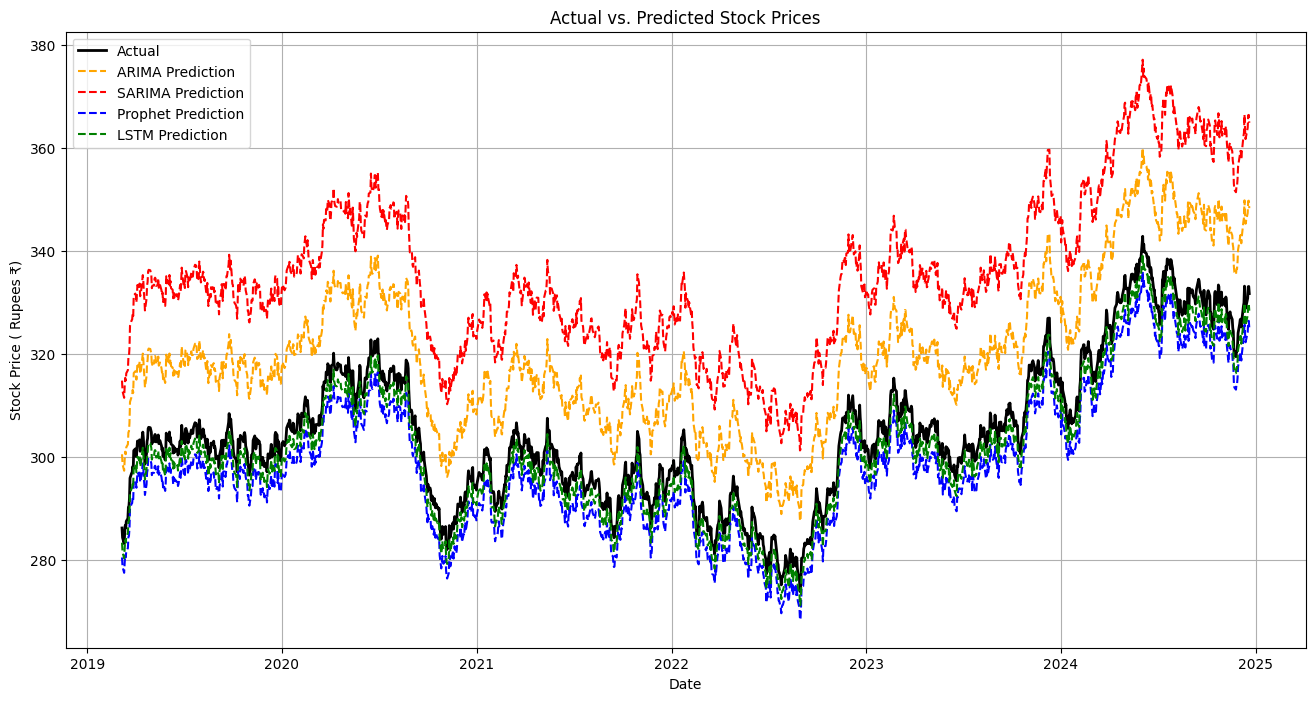

In [ ]:
# Cell 6: Plot Actual vs. All Predicted Prices (Single Plot)
# Plot actual vs. predicted prices for all models
def plot_actual_vs_predicted():
    global test, arima_predictions, sarima_predictions, merged_df
    if 'test' not in globals() or 'arima_predictions' not in globals():
        print("Error: Please generate predictions first by running the previous cell.")
        return

    # Create a figure for the comparison plot
    plt.figure(figsize=(16, 8))

    # Plot actual and predicted prices
    plt.plot(test.index, test['Close'], label='Actual', color='black', linewidth=2)
    plt.plot(test.index, arima_predictions, label='ARIMA Prediction', color='orange', linestyle='--')
    plt.plot(test.index, sarima_predictions, label='SARIMA Prediction', color='red', linestyle='--')
    plt.plot(test.index, merged_df['yhat'], label='Prophet Prediction', color='blue', linestyle='--')
    plt.plot(test.index, test['Predictions'], label='LSTM Prediction', color='green', linestyle='--')

    # Customize the plot
    plt.xlabel('Date')
    plt.ylabel('Stock Price ( Rupees ₹)')
    plt.title('Actual vs. Predicted Stock Prices')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the plotting function
plot_actual_vs_predicted()

In [ ]:
# Cell 7: Export Results
# Create and export the final DataFrame with predictions
def export_results():
    global df, test, arima_predictions, sarima_predictions, merged_df
    if 'df' not in globals() or 'test' not in globals():
        print("Error: Please upload a valid CSV file and generate predictions first.")
        return

    # Define the variables using existing data and reset index for alignment
    test_dates = test.index.to_series().reset_index(drop=True)
    actual_values = test['Close'].reset_index(drop=True)
    arima_preds = arima_predictions.reset_index(drop=True)
    sarima_preds = sarima_predictions.reset_index(drop=True)
    prophet_preds = merged_df['yhat'].reset_index(drop=True)
    lstm_preds = test['Predictions'].reset_index(drop=True)

    # Create a final DataFrame
    final_df = pd.DataFrame({
        'Date': test_dates,
        'Actual': actual_values,
        'ARIMA_Pred': arima_preds,
        'SARIMA_Pred': sarima_preds,
        'Prophet_Pred': prophet_preds,
        'LSTM_Pred': lstm_preds
    })

    # Print RMSE values and the best performing model
    performance = {
        "LSTM": mse,
        "Prophet": prophet_rmse,
        "ARIMA": arima_rmse,
        "SARIMA": sarima_rmse
    }

    best_model = min(performance, key=performance.get)
    print(f"\nThe best performing model is {best_model} with an RMSE of {performance[best_model]:.2f}.")

    # Export to CSV
    final_df.to_csv('stocks_forecast_results5.csv', index=False)
    print("Results exported to 'stocks_forecast_results5.csv'")

# Run the export function
export_results()


The best performing model is LSTM with an RMSE of 3.05.
Results exported to 'stocks_forecast_results5.csv'
